In [ ]:
# Copyright 2023 Sony Semiconductor Solutions Corp. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Edge Application SDK in a day

Using ["**Zone Detection**"](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/guides/) sample application of tutorials in AITRIOS developer site as an example,

this jupyter notebook demonstrates an overview of the "**Edge Application SDK**" in a day.

You can run this jupyter notebook step-by-step (one cell a time).

## Imports

In [7]:
import json
import subprocess
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

## Defines

### AI model dependent defines

In [8]:
# You must not change following defines.
# for AI model trained in Console for AITRIOS
INPUT_SIZE = 320
DNN_OUTPUT_DETECTIONS = 2

### "**Edge Application**" dependent defines

You can customize following **`MAX_DETECTIONS`** and **`APP_VERSION_NUMBER`**.

In [3]:
# Vision and Sensing Application can use this parameter to limit the the number of objects
# detected by AI model in an image. In this case, if AI model detects more than 10 obejects,
# Vision and Sensing Application outputs only 10 objects which has higher precision.
MAX_DETECTIONS = 10

# version number of Vision and Sensing Application for Zone Detection
APP_VERSION_NUMBER = "01.01.00"

### This notebook dependent defines

In [9]:
# You must not change following defines. You can skip reading them to understand the SDK.

SDK_ENV_ROOT_DIR = "../.."

VNSAPP_CODE_CLONE_DIR = (
    f"{SDK_ENV_ROOT_DIR}"
    "/.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs"
)
VNSAPP_CODE_DIR = "sample"
VNSAPP_DIR = "application"

## Common function

This cell defines a general utility function. So you can skip reading it to understand the SDK.

In [10]:
def run_shell_command(command: str):
    """Run shell command with output log and checking return code."""

    with subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        shell=True,
        stderr=subprocess.STDOUT,
        bufsize=1,
        close_fds=True,
    ) as process:
        # for line in iter(process.stdout.readline, b""):
        while True:
            line = process.stdout.readline()
            if line:
                print(line.rstrip().decode("utf-8"))
            if process.poll() is not None:
                break
        process.stdout.close()
        return_code = process.wait()
        if return_code != 0:
            raise subprocess.CalledProcessError(process.returncode, process.args)

### Load an image for evaluating (used as Input Tensor)

In [12]:
# You must not change following defines. You can skip reading them to understand the SDK.
IMAGES_TRAINING_DIR = "./dataset/images/training"
IMAGES_VALIDATION_DIR = "./dataset/images/validation"

In [13]:
IMAGE_INPUT = f"{IMAGES_VALIDATION_DIR}/standup_image_for_test.png"
image = cv2.cvtColor(cv2.imread(IMAGE_INPUT), cv2.COLOR_BGR2RGB)
image = cv2.resize(image, dsize=(INPUT_SIZE, INPUT_SIZE))

## Prepare AI model

Create the Custom Vision model using "**Console for AITRIOS**" Web UI. <br>
See ["**Console User Manual**"](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/documents/console-user-manual/) for details.

Use the dataset pre-installed in the SDK for training.

## Prepare "**Edge Application**"

### What is "**Edge Application**"?

"**Edge Application**" is post-processing application of AI model's Output Tensor running on Edge AI Device.

Please see [../../tutorials/4_prepare_application/1_develop/README.md](../../tutorials/4_prepare_application/1_develop/README.md) for details.

In "**Edge Application**" for "**Zone Detection**", by calculating IoU (Intersection over Union) in Edge AI Device, there is an advantage that the amount of uploading data to the cloud can be reduced.

### Set up environment for developing "**Edge Application**"

#### Copy Makefile customized for the SDK environment

In [14]:
run_shell_command(
    f"cp {VNSAPP_DIR}/Makefile_VnS \
        {VNSAPP_CODE_CLONE_DIR}/{VNSAPP_CODE_DIR}/sample/vision_app/single_dnn/keypointdetection/"
)
print(
    f"cp {VNSAPP_DIR}/Makefile_VnS \
        {VNSAPP_CODE_CLONE_DIR}/{VNSAPP_CODE_DIR}/sample/vision_app/single_dnn/keypointdetection/"
)

/usr/local/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


cp application/Makefile_VnS         ../../.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/


### Develop and build "**Edge Application**"

#### Common function

In [15]:
def build_wasm():
    """build Vision and Sensing Application and copy the compiled Wasm file to this notebook's
    directory"""

    run_shell_command(f"{VNSAPP_DIR}/build.sh")
    run_shell_command(
        f"cp -f {VNSAPP_CODE_CLONE_DIR}/{VNSAPP_CODE_DIR}"
        "/sample/vision_app/single_dnn/keypointdetection/build/release/"
        "vision_app_keypointdetection.wasm"
        f" ./{VNSAPP_DIR}/"
    )
    print(f"\nCompiled Wasm file path: ./{VNSAPP_DIR}/vision_app_keypointdetection.wasm")

print(f"{VNSAPP_DIR}/build.sh")
print(f"cp -f {VNSAPP_CODE_CLONE_DIR}/{VNSAPP_CODE_DIR}"
        "/sample/vision_app/single_dnn/keypointdetection/build/release/"
        "vision_app_keypointdetection.wasm"
        f" ./{VNSAPP_DIR}/")
print(f"\nCompiled Wasm file path: ./{VNSAPP_DIR}/vision_app_keypointdetection.wasm")

application/build.sh
cp -f ../../.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/build/release/vision_app_keypointdetection.wasm ./application/

Compiled Wasm file path: ./application/vision_app_keypointdetection.wasm


#### Modify the source code (if needed)

The source code exists in [./../../.devcontainer/dependencies/aitrios-sdk-zone-detection-webapp-cs/sample](./../../.devcontainer/dependencies/aitrios-sdk-zone-detection-webapp-cs/sample).

Please modify the source code if needed.

#### Build Wasm

"**Edge Application**" is compiled to Wasm file.

> **NOTE**
>
> If docker image for building Wasm doesn't cached, it takes about 4 minutes.

In [16]:
build_wasm()

build_keypointdetection
mkdir -p /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/build/release/sample/vision_app/single_dnn/keypointdetection/src/
/opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysroot/ -I ./include -I /root/schema -I ../../../../vision_app_sdk/include -I ../../../../third_party/include -I ../../../../third_party/include/parson -O2 -I ../../../../sample/include/keypointdetection -I ../../../../sample/post_process/keypointdetection/include -o src/vision_app_keypointdetection.o -c src/vision_app_keypointdetection.cpp -o /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/build/release/sample/vision_app/single_dnn/keypointdetection/src/vision_app_keypointdetection.o
# /opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysr

## Run "**Edge Application**" with mock

The SDK provides the test application for running "**Edge Application**", that mocks dependency libraries of Edge AI Device firmware.

So you can run "**Edge Application**" in the SDK environment for development and test.

Please see [../../tutorials/4_prepare_application/1_develop/README_wasmdebug.md](../../tutorials/4_prepare_application/1_develop/README_wasmdebug.md) for details.

> **NOTE**
>
> In the test application, the input of "**Edge Application**" is an array from the [output_tensor.jsonc](./application/output_tensor.jsonc) file.


### Defines

In [17]:
# You must not change following defines. You can skip reading them to understand the SDK.

PPL_ENV_DIR = f"{SDK_ENV_ROOT_DIR}/tutorials/4_prepare_application/1_develop"
PPL_ENV_OUTPUT_DIR = "testapp/build/loader"
PPL_ENV_OUTPUT_FILE = "serialized_result_01.bin"

### Common functions

These cells define general utility function. So you can skip reading them to understand the SDK.

In [18]:
def display_deserialized_inference_result(
    file_path: str, image: cv2.Mat, ppl_parameter
):
    """Display an image with overlaid metadata of inference result"""

    plt.figure()

    with open(file_path, "r") as f:
        json_load = json.load(f)

    detection_list = json_load["perception"]["object_detection_list"]

    overlaid_text_image = np.zeros((INPUT_SIZE, INPUT_SIZE, 4), dtype=np.uint8)
    result_image = image.copy()
    result_image = cv2.cvtColor(result_image, cv2.COLOR_RGB2RGBA)
    if (
        "zone" in ppl_parameter
        and "top_left_x" in ppl_parameter["zone"]
        and "top_left_y" in ppl_parameter["zone"]
        and "bottom_right_x" in ppl_parameter["zone"]
        and "bottom_right_y" in ppl_parameter["zone"]
    ):
        zone_xmin = ppl_parameter["zone"]["top_left_x"]
        zone_ymin = ppl_parameter["zone"]["top_left_y"]
        zone_xmax = ppl_parameter["zone"]["bottom_right_x"]
        zone_ymax = ppl_parameter["zone"]["bottom_right_y"]
        cv2.rectangle(
            result_image,
            (zone_xmin, zone_ymin),
            (zone_xmax, zone_ymax),
            (255, 0, 0, 255),
            2,
        )

    for idx, detection in enumerate(detection_list):
        bbox = detection["bounding_box"]
        score = detection["score"]
        iou = detection["iou"]
        zoneflag = detection["zoneflag"]
        xmin, ymin, xmax, ymax = bbox.values()
        if zoneflag:
            rectangle_color = (255, 255, 0, 255)
        else:
            rectangle_color = (255, 255, 0, 255)
        cv2.rectangle(result_image, (xmin, ymin), (xmax, ymax), rectangle_color, 2)

        text_pos_x = xmin + 2
        text_pos_y = ymin + 13
        if text_pos_x > (INPUT_SIZE - 35):
            text_pos_x = INPUT_SIZE - 35
        elif text_pos_x < 2:
            text_pos_x = 2
        if text_pos_y < 13:
            text_pos_y = 13
        elif text_pos_y > (INPUT_SIZE - 15):
            text_pos_y = INPUT_SIZE - 15
        cv2.putText(
            overlaid_text_image,
            str("{0:.0f}%".format(iou * 100.0)),
            (text_pos_x, text_pos_y),
            cv2.FONT_HERSHEY_PLAIN,
            1,
            (0, 255, 0, 255),
            1,
            cv2.LINE_AA,
        )

        text_pos_x = xmin + 2
        text_pos_y = ymax - 2
        if text_pos_x > (INPUT_SIZE - 35):
            text_pos_x = INPUT_SIZE - 35
        elif text_pos_x < 2:
            text_pos_x = 2
        if text_pos_y < 26:
            text_pos_y = 26
        elif text_pos_y > (INPUT_SIZE - 2):
            text_pos_y = INPUT_SIZE - 2
        cv2.putText(
            overlaid_text_image,
            str("{0:.0f}%".format(score * 100.0)),
            (text_pos_x, text_pos_y),
            cv2.FONT_HERSHEY_PLAIN,
            1,
            (255, 255, 0, 255),
            1,
            cv2.LINE_AA,
        )

    cv2.add(result_image, overlaid_text_image, result_image)
    plt.imshow(result_image)
    plt.axis("off")
    plt.show()
    plt.clf()
    plt.close()

In [19]:
def deserialize_output_tensor(serialized_output_tensor_file_name: str):
    """Deserialize Output Tensor binary file to json file"""

    run_shell_command(
        f"cp $(pwd)/{VNSAPP_CODE_CLONE_DIR}/{VNSAPP_CODE_DIR}/schema/keypointdetection.fbs \
            $(pwd)/deserialize/keypointdetection.fbs"
    )
    run_shell_command(
        f"cd $(pwd)/deserialize/ \
        && ./binary_to_json.sh keypointdetection.fbs {serialized_output_tensor_file_name} ./"
    )

In [20]:
print(f"cp $(pwd)/{VNSAPP_CODE_CLONE_DIR}/{VNSAPP_CODE_DIR}/schema/keypointdetection.fbs \
            $(pwd)/deserialize/keypointdetection.fbs")

cp $(pwd)/../../.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/schema/keypointdetection.fbs             $(pwd)/deserialize/keypointdetection.fbs


### Prepare PPL Parameter and run "**Edge Application**"

PPL Parameter is used for customizing behavior of "**Edge Application**" by setting parameters.

#### Create PPL Parameter and save it as json

At first, use following PPL Parameter as provisional values for building and running "**Edge Application**" in the SDK environment. The **`zone`** value is incorrect and the **`threshold`** value is set too high.

In [19]:
ppl_parameter_before = {
    "header": {"id": "00", "version": APP_VERSION_NUMBER},
    "dnn_output_detections": DNN_OUTPUT_DETECTIONS,
    "max_detections": MAX_DETECTIONS,
    "mode": 0,  # mode of "Zone Detection" application. 0: detections not filtered by IoU, 1: detections filtered by IoU
    "zone": {
        "top_left_x": 10,
        "top_left_y": 100,
        "bottom_right_x": 200,
        "bottom_right_y": 250,
    },
    "threshold": {"iou": 0.9, "score": 0.8},
    "input_width": INPUT_SIZE,
    "input_height": INPUT_SIZE,
}

with open(f"./{VNSAPP_DIR}/ppl_parameter_before.json", "w") as fp:
    json.dump(ppl_parameter_before, fp, indent=4)
    print(f"PPL Parameter saved as ./{VNSAPP_DIR}/ppl_parameter_before.json")

PPL Parameter saved as ./application/ppl_parameter_before.json


#### Build and run "**Edge Application**" in the SDK with mock library

Running "**Edge Application**" in the SDK with mock library, metadata of inference result serialized by FlatBuffers is generated as a result.

To read the result, deserialize the metadata of inference result.

> **NOTE**
>
> If docker image for deserialize isn't cached, it takes about 3 minutes.

In [16]:
print(f"{VNSAPP_DIR}/start.sh \
                  -o $(pwd)/{VNSAPP_DIR}/output_tensor.jsonc \
                  -p $(pwd)/{VNSAPP_DIR}/ppl_parameter_before.json")

application/start.sh                   -o $(pwd)/application/output_tensor.jsonc                   -p $(pwd)/application/ppl_parameter_before.json


In [20]:
# Run Wasm on the SDK environment
run_shell_command(
    f"{VNSAPP_DIR}/start.sh \
                  -o $(pwd)/{VNSAPP_DIR}/output_tensor.jsonc \
                  -p $(pwd)/{VNSAPP_DIR}/ppl_parameter_before.json"
)

# Copy metadata of inference result from test application directory to this notebook directory
run_shell_command(
    f"mkdir -p $(pwd)/deserialize && \
        cp -f $(pwd)/{PPL_ENV_DIR}/{PPL_ENV_OUTPUT_DIR}/{PPL_ENV_OUTPUT_FILE} \
            $(pwd)/deserialize/ppl_output_before.bin"
)
print(
    "\nSerialized metadata of inference result binary file path: \
        ./deserialize/ppl_output_before.bin"
)

# Deserialize
BINARY_FILE = "ppl_output_before.bin"
deserialize_output_tensor(BINARY_FILE)
print(
    "\nDeserialized metadata of inference result json file path: \
        ./deserialize/ppl_output_before.json"
)

build_keypointdetection
mkdir -p /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/build/release/sample/vision_app/single_dnn/keypointdetection/src/
/opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysroot/ -I ./include -I /root/schema -I ../../../../vision_app_sdk/include -I ../../../../third_party/include -I ../../../../third_party/include/parson -O2 -I ../../../../sample/include/keypointdetection -I ../../../../sample/post_process/keypointdetection/include -o src/vision_app_keypointdetection.o -c src/vision_app_keypointdetection.cpp -o /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/build/release/sample/vision_app/single_dnn/keypointdetection/src/vision_app_keypointdetection.o
# /opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysr

CalledProcessError: Command 'cd $(pwd)/deserialize/         && ./binary_to_json.sh keypointdetection.fbs ppl_output_before.bin ./' returned non-zero exit status 139.

In [26]:
# Run Wasm on the SDK environment
run_shell_command(
    f"{VNSAPP_DIR}/start.sh \
                  -o $(pwd)/{VNSAPP_DIR}/output_tensor.jsonc \
                  -p $(pwd)/{VNSAPP_DIR}/ppl_parameter_before.json"
)

# Copy metadata of inference result from test application directory to this notebook directory
run_shell_command(
    f"mkdir -p $(pwd)/deserialize && \
        cp -f $(pwd)/{PPL_ENV_DIR}/{PPL_ENV_OUTPUT_DIR}/{PPL_ENV_OUTPUT_FILE} \
            $(pwd)/deserialize/ppl_output_before.bin"
)
print(
    "\nSerialized metadata of inference result binary file path: \
        ./deserialize/ppl_output_before.bin"
)

# Deserialize
BINARY_FILE = "ppl_output_before.bin"
deserialize_output_tensor(BINARY_FILE)
print(
    "\nDeserialized metadata of inference result json file path: \
        ./deserialize/ppl_output_before.json"
)

build_keypointdetection
mkdir -p /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/build/release/sample/vision_app/single_dnn/keypointdetection/src/
/opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysroot/ -I ./include -I /root/schema -I ../../../../vision_app_sdk/include -I ../../../../third_party/include -I ../../../../third_party/include/parson -O2 -I ../../../../sample/include/keypointdetection -I ../../../../sample/post_process/keypointdetection/include -o src/vision_app_keypointdetection.o -c src/vision_app_keypointdetection.cpp -o /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-keypoint-detection-webapp-cs/sample/sample/vision_app/single_dnn/keypointdetection/build/release/sample/vision_app/single_dnn/keypointdetection/src/vision_app_keypointdetection.o
# /opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysr

CalledProcessError: Command 'mkdir -p $(pwd)/deserialize &&         cp -f $(pwd)/../../tutorials/4_prepare_application/1_develop/testapp/build/loader/serialized_result_01.bin             $(pwd)/deserialize/ppl_output_before.bin' returned non-zero exit status 1.

In [18]:
print(
    f"mkdir -p $(pwd)/deserialize && \
        cp -f $(pwd)/{PPL_ENV_DIR}/{PPL_ENV_OUTPUT_DIR}/{PPL_ENV_OUTPUT_FILE} \
            $(pwd)/deserialize/ppl_output_before.bin"
)

mkdir -p $(pwd)/deserialize &&         cp -f $(pwd)/../../tutorials/4_prepare_application/1_develop/testapp/build/loader/serialized_result_01.bin             $(pwd)/deserialize/ppl_output_before.bin


In [21]:
print(
    f"{VNSAPP_DIR}/start.sh \
                  -o $(pwd)/{VNSAPP_DIR}/output_tensor.jsonc \
                  -p $(pwd)/{VNSAPP_DIR}/ppl_parameter_before.json"
)
print(
    f"mkdir -p $(pwd)/deserialize && \
        cp -f $(pwd)/{PPL_ENV_DIR}/{PPL_ENV_OUTPUT_DIR}/{PPL_ENV_OUTPUT_FILE} \
            $(pwd)/deserialize/ppl_output_before.bin"
)
print(
    "\nSerialized metadata of inference result binary file path: \
        ./deserialize/ppl_output_before.bin"
)
print(
    "\nDeserialized metadata of inference result json file path: \
        ./deserialize/ppl_output_before.json"
)

application/start.sh                   -o $(pwd)/application/output_tensor.jsonc                   -p $(pwd)/application/ppl_parameter_before.json
mkdir -p $(pwd)/deserialize &&         cp -f $(pwd)/../../tutorials/4_prepare_application/1_develop/testapp/build/loader/serialized_result_01.bin             $(pwd)/deserialize/ppl_output_before.bin

Serialized metadata of inference result binary file path:         ./deserialize/ppl_output_before.bin

Deserialized metadata of inference result json file path:         ./deserialize/ppl_output_before.json


#### Display deserialized metadata of inference result

Since the PPL Parameter are provisional values, the result will not be expected.

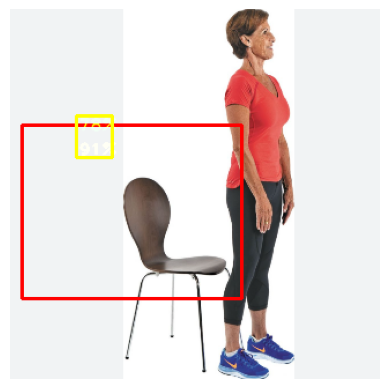

In [22]:
file_path = "./deserialize/ppl_output_before.json"
display_deserialized_inference_result(file_path, image, ppl_parameter_before)

# Display legend
# Yellow rectangle: detected object
# Yellow text: inference score of detected object
# Red rectangle: zone defined in PPL Parameter
# Green text: IoU (Intersection over Union) with detected object and zone

### Modify PPL Parameter and run "**Edge Application**"

#### Create PPL Parameter and save it as json (second time)

Before running following cell, you can customize the PPL Parameter.

For example, following **`mode`**, **`zone`** and **`threshold`**.

In [27]:
ppl_parameter_after = {
    "header": {"id": "00", "version": "01.01.00"},
    "dnn_output_detections": DNN_OUTPUT_DETECTIONS,
    "max_detections": MAX_DETECTIONS,
    "mode": 0,  # mode of "Zone Detection" application. 0: detections not filtered by IoU, 1: detections filtered by IoU
    "zone": {
        "top_left_x": 11,
        "top_left_y": 179,
        "bottom_right_x": 212,
        "bottom_right_y": 276,
    },
    "threshold": {"iou": 0.5, "score": 0.4},
    "input_width": INPUT_SIZE,
    "input_height": INPUT_SIZE,
}

with open(f"./{VNSAPP_DIR}/ppl_parameter_after.json", "w") as fp:
    json.dump(ppl_parameter_after, fp, indent=4)
    print(f"PPL Parameter saved as ./{VNSAPP_DIR}/ppl_parameter_after.json")

PPL Parameter saved as ./application/ppl_parameter_after.json


#### Build and run "**Edge Application**" in the SDK with mock library (second time)

In [28]:
# Run Wasm on the SDK environment
run_shell_command(
    f"{VNSAPP_DIR}/start.sh \
        -o $(pwd)/{VNSAPP_DIR}/output_tensor.jsonc \
        -p $(pwd)/{VNSAPP_DIR}/ppl_parameter_after.json"
)

# Copy metadata of inference result from test application directory to this notebook directory
run_shell_command(
    f"mkdir -p $(pwd)/deserialize && \
        cp -f $(pwd)/{PPL_ENV_DIR}/{PPL_ENV_OUTPUT_DIR}/{PPL_ENV_OUTPUT_FILE} \
            $(pwd)/deserialize/ppl_output_after.bin"
)
print(
    "\nSerialized metadata of inference result binary file path: \
        ./deserialize/ppl_output_after.bin"
)

# Deserialize
BINARY_FILE = "ppl_output_after.bin"
deserialize_output_tensor(BINARY_FILE)
print(
    "\nDeserialized metadata of inference result json file path: \
        ./deserialize/ppl_output_after.json"
)

/usr/local/lib/python3.8/subprocess.py:848: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


build_zonedetection
mkdir -p /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-zone-detection-webapp-cs/sample/sample/vision_app/single_dnn/zonedetection/build/release/sample/vision_app/single_dnn/zonedetection/src/
/opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysroot/ -I ./include -I /root/schema -I ../../../../vision_app_sdk/include -I ../../../../third_party/include -I ../../../../third_party/include/parson -O2 -I ../../../../sample/include/zonedetection -I ../../../../sample/post_process/zonedetection/include -o src/vision_app_zonedetection.o -c src/vision_app_zonedetection.cpp -o /workspaces/aitrios-sdk-vision-sensing-app/.devcontainer/dependencies/aitrios-sdk-zone-detection-webapp-cs/sample/sample/vision_app/single_dnn/zonedetection/build/release/sample/vision_app/single_dnn/zonedetection/src/vision_app_zonedetection.o
# /opt/wasi-sdk/bin/clang++ --sysroot=/opt/wasi-sdk/share/wasi-sysroot/ -I ./include -I /root/schema -I ../../../..

#### Display deserialized metadata of inference result (second time)

Since the PPL Parameter are configured values, the result will be expected.

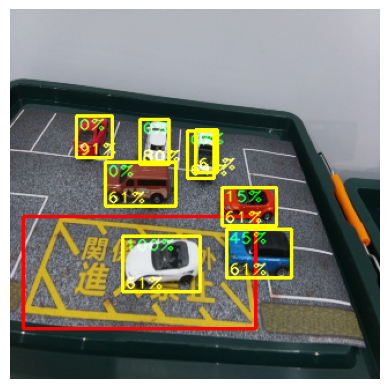

In [29]:
file_path = "./deserialize/ppl_output_after.json"
display_deserialized_inference_result(file_path, image, ppl_parameter_after)

# Display legend
# Yellow rectangle: detected object
# Yellow text: inference score of detected object
# Red rectangle: zone defined in PPL Parameter
# Green text: IoU (Intersection over Union) with detected object and zone

## Deploy AI model and "**Edge Application**"

Deploy AI model and "**Edge Application**" to your Edge AI Device using "**Console Access Library**".

### Imports

In [ ]:
import base64
import errno
import os

import jsonschema
import pandas as pd
from console_access_library.client import Client
from console_access_library.common.config import Config
from IPython.display import display

### Defines

In [ ]:
# You must not change following defines. You can skip reading them to understand the SDK.

CONNECTION_CONFIG_PATH = (
    f"{SDK_ENV_ROOT_DIR}/tutorials/_common/set_up_console_client/configuration.json"
)
CONNECTION_CONFIG_SCHEMA_PATH = (
    f"{SDK_ENV_ROOT_DIR}"
    "/tutorials/_common/set_up_console_client/configuration_schema.json"
)

### Common function

This cell defines a general utility function. So you can skip reading it to understand the SDK.

In [ ]:
def validate_symlink(path: Path):
    """Validate symbolic link"""

    if path.is_symlink():
        raise OSError(
            errno.ELOOP,
            "Symbolic link is not supported. Please use real folder or file",
            f"{path}",
        )

### Prepare configurations for connection

#### Create Configuration file for connection (only at first time)

In [ ]:
configuration_path = Path(f"{CONNECTION_CONFIG_PATH}")
if not configuration_path.is_file():
    with open(configuration_path, "w") as fp:
        configuration_connection = {
            "console_endpoint": "",
            "portal_authorization_endpoint": "",
            "client_secret": "",
            "client_id": "",
        }
        json.dump(configuration_connection, fp, indent=4)
    print(f"./{CONNECTION_CONFIG_PATH} is created.")
else:
    print(f"./{CONNECTION_CONFIG_PATH} already exists.")

#### Edit Configuration file for connection

Edit the parameters in [./../../tutorials/_common/set_up_console_client/configuration.json](../../tutorials/_common/set_up_console_client/configuration.json).

The parameters required to run this notebook are :

|Setting|Range|Required/Optional|Remarks
|:--|:--|:--|:--|
|**`console_endpoint`**|String.<br>See NOTE.|Required|Used for "**Console Access Library**" API: **`common.config.Config`**
|**`portal_authorization_endpoint`**|String.<br>See NOTE.|Required|Used for "**Console Access Library**" API: **`common.config.Config`**
|**`client_secret`**|String.<br>See NOTE.|Required|Used for "**Console Access Library**" API: **`common.config.Config`**
|**`client_id`**|String.<br>See NOTE.|Required|Used for "**Console Access Library**" API: **`common.config.Config`**

> **NOTE**
>
> See [API Reference](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/guides/) of "**Console Access Library**" for other restrictions.

### Load Configurations for connection

In [ ]:
configuration_path = Path(f"{CONNECTION_CONFIG_PATH}")
validate_symlink(configuration_path)

# Load configuration file.
with open(configuration_path, "r") as f:
    json_load = json.load(f)

configuration_schema_path = Path(f"{CONNECTION_CONFIG_SCHEMA_PATH}")
validate_symlink(configuration_schema_path)

# Load configuration schema file.
with open(configuration_schema_path, "r") as f:
    json_schema = json.load(f)

# Validate configuration.
jsonschema.validate(json_load, json_schema)

print(f"./{CONNECTION_CONFIG_PATH} is loaded.")

### Set up "**Console Access Library**"

#### Instantiate "**Console Access Library**" and get device list with AI model info

In [ ]:
def get_devices_and_ai_models(client_obj: Client):
    """Get device list with AI model info"""

    # Get an instance of device management API
    device_management_obj = client_obj.get_device_management()

    # Call an API for get device list
    try:
        response = device_management_obj.get_devices()
    except Exception as e:
        # EXCEPTION
        raise e

    # response error check
    if "result" in response and response["result"] != "SUCCESS":
        # ERROR
        raise ValueError("ERROR", response)

    print("Get device list complete.")

    # Create output list
    model_lists = []
    devices = response.get("devices", [])

    for device in devices:
        device_id = device.get("device_id", "")

        model_list = []
        model_list.append(device_id)
        models = device.get("models", [])
        if any(models):
            for model in models:
                version_id = ""
                model_version_id = model.get("model_version_id", "")
                if len(model_version_id) == 0:
                    # There is no models deployed on the device
                    model_id = ""
                elif ":" not in model_version_id:
                    # The model deployed to the device does not exist in Console database
                    model_id = model_version_id
                else:
                    # Split string to model_id and version_id
                    model_version_id_list = model_version_id.split(":v")

                    model_id = model_version_id_list[0]
                    version_id = model_version_id_list[1]

                model_list.append(model_id)
                model_list.append(version_id)

            # Fill missing elements with empty string
            model_list = model_list + ["" for x in range(9 - len(model_list))]

            model_lists.append(model_list)
        else:
            # There is no models deployed on the device
            model_list.append("")

            # Fill missing elements with empty string
            model_list = model_list + ["" for x in range(9 - len(model_list))]

            model_lists.append(model_list)

    if len(model_lists) == 0:
        raise Exception("There is no data in the device list.")

    output_frame = pd.DataFrame(
        model_lists,
        columns=["Device ID", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"],
    )

    # Specify "Device ID" column as index row
    output_frame.set_index("Device ID", inplace=True)

    # Set column to 2 rows
    double_columns_num = pd.MultiIndex.from_arrays(
        [
            ["Model 1", " ", "Model 2", " ", "Model 3", " ", "Model 4", " "],
            ["ID", "Version", "ID", "Version", "ID", "Version", "ID", "Version"],
        ]
    )

    # Change column
    output_frame.columns = double_columns_num

    # setting backup
    backup_max_rows = pd.options.display.max_rows
    # output limit clear
    pd.set_option("display.max_rows", None)
    display(output_frame)
    # setting restore
    pd.set_option("display.max_rows", backup_max_rows)


print("Create access lib client...")

auth_param = {}
auth_param["console_endpoint"] = json_load["console_endpoint"]
auth_param["portal_authorization_endpoint"] = json_load["portal_authorization_endpoint"]
auth_param["client_secret"] = json_load["client_secret"]
auth_param["client_id"] = json_load["client_id"]

try:
    config_obj = Config(**auth_param)
except Exception as e:
    # EXCEPTION
    raise e

# Instantiate Console Access Library Client.
client_obj = Client(config_obj)

# Get device and model information for deploying to device
get_devices_and_ai_models(client_obj)

### Prepare configurations

#### Create Configuration file (only at first time)

In [ ]:
configuration_path = Path("./configuration.json")
if not configuration_path.is_file():
    model_id = "YOUR_AI_MODEL_ID"

    ppl_file = f"{VNSAPP_DIR}/vision_app_zonedetection.wasm"
    app_name = "YOUR_APP_NAME"
    app_version_number = APP_VERSION_NUMBER

    config_id = "YOUR_CONFIG_ID"

    device_id = "YOUR_DEVICE_ID"

    command_parameter_file_name = "command_parameter_file.json"

    with open(configuration_path, "w") as fp:
        configuration = {
            "import_app": {
                "ppl_file": ppl_file,
                "app_name": app_name,
                "version_number": app_version_number,
                "comment": "YOUR_APP_COMMENT",
            },
            "deploy_model": {
                "should_create_deploy_config": True,
                "config_id": config_id,
                "create_config": {
                    "comment": "YOUR_CONFIGURATION_COMMENT",
                    "model_id": model_id,
                    # "model_version_number": ""
                },
                "device_ids": [device_id],
                # "replace_model_id": "",
                "comment": "YOUR_MODEL_DEPLOY_COMMENT",
            },
            "deploy_app": {
                "app_name": app_name,
                "version_number": app_version_number,
                "device_ids": [device_id],
                "comment": "YOUR_APP_DEPLOY_COMMENT",
            },
            "command_parameter_file_name": command_parameter_file_name,
        }
        json.dump(configuration, fp, indent=4)
    print("./configuration.json is created.")
else:
    print("./configuration.json already exists.")

#### Edit Configuration file

Edit the parameters in [configuration.json](./configuration.json).

|Setting|Description|Range|Required/Optional|Remarks
|:--|:--|:--|:--|:--|
|**`import_app`**||Object.<br>See following table of import_app|Required||
|**`deploy_model`**||Object.<br>See following table of deploy_model|Required||
|**`deploy_app`**||Object.<br>See following table of deploy_app|Required||
|**`command_parameter_file_name`**|The filename of the Command Parameter you want to save.|String.|Required|Saving filename in the SDK.<br>The file is used for uploading to "**Console for AITRIOS**"|

##### import_app

|Setting|Description|Range|Required/Optional|Remarks
|:--|:--|:--|:--|:--|
|**`ppl_file`**|The path to the "**Edge Application**" file for importing |Absolute path or relative path from configuration.json/Notebook(*.ipynb)|Required||
|**`app_name`**|The name of the "**Edge Application**" you want to import|String. <br>See NOTE. |Required|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.import_device_app`**|
|**`version_number`**|The version number of the "**Edge Application**" you want to import |String. <br>See NOTE. |Required|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.import_device_app`** |
|**`comment`**|The description of the "**Edge Application**" |String. <br>See NOTE. |Optional|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.import_device_app`** |

> **NOTE**
>
> See [API Reference](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/guides/) of "**Console Access Library**" for other restrictions.

##### deploy_model

|Setting||Description|Range|Required/Optional|Remarks
|:--|:--|:--|:--|:--|:--|
|**`should_create_deploy_config`**||Whether to register a new deploy configuration.<br>If true, create a new configuration; if false, use an already registered configuration specified by **`config_id`**.|true or false|Required||
|**`config_id`**||The ID of the deploy configuration you want to use for deployment.|String.<br>See NOTE.|Required|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.create_deploy_configuration`**<br>**`deployment.deployment.Deployment.deploy_by_configuration`**|
|**`create_config`**|**`comment`**|Description of the configuration.|String. <br>See NOTE.|Optional|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.create_deploy_configuration`**|
||**`model_id`**|The ID of the model you want to deploy.|String.<br>See NOTE.|Optional<br> Required if **`should_create_deploy_config`** is true.|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.create_deploy_configuration`**|
||**`model_version_number`**|The version of the model you want to deploy.|String.<br>See NOTE.|Optional|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.create_deploy_configuration`**|
|**`device_ids`**||List of device ids on which you want to deploy your model.|List of string.|Required|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.deploy_by_configuration`**|
|**`replace_model_id`**||The ID of the model you want to replace.|String.<br>See NOTE.|Optional|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.deploy_by_configuration`**|
|**`comment`**||Description of the deployment.|String.<br>See NOTE.|Optional|Used for "**Console Access Library**" API:<br>**`deployment.deployment.Deployment.deploy_by_configuration`**|

> **NOTE**
>
> See [API Reference](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/guides/) of "**Console Access Library**" for other restrictions.

##### deploy_app

|Setting|Description|Range|Required/Optional|Remarks
|:--|:--|:--|:--|:--|
|**`app_name`**|The name of the "**Edge Application**" you want to deploy.|String.<br>See NOTE.|Required|Used for "**Console Access Library**" API: <br> **`deployment.deployment.Deployment.deploy_device_app`** <br> **`deployment.deployment.Deployment.get_device_app_deploys`**|
|**`version_number`**|The version number of the "**Edge Application**" you want deploy.|String.<br>See NOTE.|Required|Used for "**Console Access Library**" API: <br> **`deployment.deployment.Deployment.deploy_device_app`** <br> **`deployment.deployment.Deployment.get_device_app_deploys`**|
|**`device_ids`**|List of device ids on which you want to deploy your "**Edge Application**".|List of strings.|Required|Used for "**Console Access Library**" API: <br> **`deployment.deployment.Deployment.deploy_device_app`**|
|**`comment`**|Description of the deployment.|String.<br>See NOTE.|Optional|Used for "**Console Access Library**" API: <br> **`deployment.deployment.Deployment.deploy_device_app`**|

> **NOTE**
>
> See [API Reference](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/guides/) of "**Console Access Library**" for other restrictions.

### Load Configurations (for importing and deploying)

In [ ]:
configuration_path = Path("./configuration.json")
validate_symlink(configuration_path)

# Load configuration file.
with open(configuration_path, "r") as f:
    json_load = json.load(f)

configuration_schema_path = Path("./configuration_schema.json")
validate_symlink(configuration_schema_path)

# Load configuration schema file.
with open(configuration_schema_path, "r") as f:
    json_schema = json.load(f)

# Validate configuration.
jsonschema.validate(json_load, json_schema)

IMPORT_APP_SCHEMA_PATH = (
    f"{SDK_ENV_ROOT_DIR}/tutorials/4_prepare_application/"
    "2_import_to_console/configuration_schema.json"
)
DEPLOY_MODEL_SCHEMA_PATH = (
    f"{SDK_ENV_ROOT_DIR}/tutorials/3_prepare_model/develop_on_sdk/"
    "4_deploy_to_device/deploy_to_device/configuration_schema.json"
)
DEPLOY_APP_SCHEMA_PATH = (
    f"{SDK_ENV_ROOT_DIR}/tutorials/4_prepare_application/"
    "3_deploy_to_device/configuration_schema.json"
)


def validate_objects(schema_path: str, key: str):
    configuration_schema_path = Path(schema_path)
    validate_symlink(configuration_schema_path)
    # Load configuration schema file.
    with open(configuration_schema_path, "r") as f:
        json_schema = json.load(f)
    # Validate configuration.
    jsonschema.validate(json_load[key], json_schema)


validate_objects(IMPORT_APP_SCHEMA_PATH, "import_app")
validate_objects(DEPLOY_MODEL_SCHEMA_PATH, "deploy_model")
validate_objects(DEPLOY_APP_SCHEMA_PATH, "deploy_app")

print("./configuration.json is loaded.")

### Import "**Edge Application**" to "**Console**"

#### Import "**Edge Application**"

In [ ]:
def import_app(json_load):
    """Import Vision and Sensing Application to Console"""

    # encode base 64
    def convert_file_to_b64_string(file_path):
        with open(file_path, "rb") as f:
            return base64.b64encode(f.read())

    ppl_file = Path(json_load["ppl_file"].replace(os.path.sep, "/"))
    validate_symlink(ppl_file)

    file_content = convert_file_to_b64_string(ppl_file)

    file_name = os.path.basename(ppl_file)

    print(json_load["ppl_file"] + " is loaded.")

    vasa_import_param = {}
    vasa_import_param["app_name"] = json_load["app_name"]
    vasa_import_param["version_number"] = json_load["version_number"]
    vasa_import_param["compiled_flg"] = "0"
    vasa_import_param["entry_point"] = "main"
    vasa_import_param["file_name"] = file_name
    vasa_import_param["file_content"] = file_content
    if "comment" in json_load:
        vasa_import_param["comment"] = json_load["comment"]

    # Call an API to import Vision and Sensing Application into Console for AITRIOS
    try:
        deployment_obj = client_obj.get_deployment()
        # print(vasa_import_param)
        response = deployment_obj.import_device_app(**vasa_import_param)
    except Exception as e:
        # EXCEPTION
        raise e

    # response error check
    if "result" in response and response["result"] != "SUCCESS":
        # ERROR
        raise ValueError("ERROR", response)

    # SUCCESS
    print(
        "Start to import the Vision and Sensing Application."
        + " \n\tapp_name: "
        + json_load["app_name"]
        + "\n\tversion_number: "
        + json_load["version_number"]
    )


import_app(json_load["import_app"])

#### Check "**Edge Application**" status

To complete the conversion, ensure that the conversion status is **`Conversion completed`**.

After you start the conversion, run the following code cell to check the status.

> **Note**
>
> Import and conversion take several minutes.

In [ ]:
def get_device_app_status(json_load):
    """Get Vision and Sensing Application status on Console"""

    app_name = json_load["app_name"]
    version_number = json_load["version_number"]

    # Status of Vision and Sensing Application on Console
    status_dictionary = {
        "0": "Importing completed (Before conversion)",
        "1": "Converting...",
        "2": "Conversion completed",
        "3": "Conversion failed",
    }
    # Flag for import check
    import_flag = False
    # Call an API to get Vision and Sensing Application info
    try:
        deployment_obj = client_obj.get_deployment()
        response = deployment_obj.get_device_apps()
    except Exception as e:
        # EXCEPTION
        raise e

    # response error check
    if "result" in response and response["result"] != "SUCCESS":
        # ERROR
        raise ValueError("ERROR", response)

    # SUCCESS
    # Create output list
    apps = response.get("apps", [])
    for app in apps:
        if "name" in app and app["name"] == app_name:
            versions = app.get("versions", [])
            for version in versions:
                if "version" in version and version["version"] == version_number:
                    import_flag = True
                    version_status = version.get("status", "")
                    break
            if import_flag:
                break
    if import_flag:
        return status_dictionary.get(
            version_status, "Unknown status '" + version_status + "'"
        )
    else:
        raise Exception(
            "Vision and Sensing Application is not found. "
            + " \n\tapp_name: "
            + app_name
            + "\n\tversion_number: "
            + version_number
        )


def check_app_status(json_load):
    """Check Vision and Sensing Application status on Console"""

    get_status = get_device_app_status(json_load)
    print(
        get_status
        + " \n\tapp_name: "
        + json_load["app_name"]
        + "\n\tversion_number: "
        + json_load["version_number"]
    )


check_app_status(json_load["import_app"])

### Create deploy configuration in "**Console**"

To deploy AI model to Edge AI Device, deploy configuration includes information of AI model and Edge AI Device to deploy.

In [ ]:
def create_deploy_config(json_load):
    """Create deploy configuration on Console"""

    # Set values
    should_create_deploy_config = json_load["should_create_deploy_config"]

    if should_create_deploy_config is True:
        config_param = {}
        config_param["config_id"] = json_load["config_id"]
        if "create_config" in json_load:
            config_param["model_id"] = json_load["create_config"]["model_id"]
            if "model_version_number" in json_load["create_config"]:
                config_param["model_version_number"] = json_load["create_config"][
                    "model_version_number"
                ]
            if "comment" in json_load["create_config"]:
                config_param["comment"] = json_load["create_config"]["comment"]

    if should_create_deploy_config is True:
        # Call an API to create deploy configuration
        try:
            deployment_obj = client_obj.get_deployment()
            # print(config_param)
            response = deployment_obj.create_deploy_configuration(**config_param)
        except Exception as e:
            # EXCEPTION
            raise e

        # response error check
        if "result" in response and response["result"] != "SUCCESS":
            # ERROR
            raise ValueError("ERROR", response)

        # SUCCESS
        print("Deploy configuration was created.")


create_deploy_config(json_load["deploy_model"])

### Deploy model to device

#### Deploy model

In [ ]:
def deploy_model(json_load):
    """Deploy AI model to device"""

    device_ids_list = json_load["device_ids"]

    # Set values
    deploy_param = {}
    deploy_param["config_id"] = json_load["config_id"]
    deploy_param["device_ids"] = ",".join(device_ids_list)
    if "replace_model_id" in json_load:
        deploy_param["replace_model_id"] = json_load["replace_model_id"]
    if "comment" in json_load:
        deploy_param["comment"] = json_load["comment"]

    # Call an API to deploy the model to device
    try:
        deployment_obj = client_obj.get_deployment()
        # print(deploy_param)
        response = deployment_obj.deploy_by_configuration(**deploy_param)
    except Exception as e:
        # EXCEPTION
        raise e

    # response error check
    if "result" in response and response["result"] != "SUCCESS":
        # ERROR
        raise ValueError("ERROR", response)

    # SUCCESS
    print("Start to deploy the model.")


deploy_model(json_load["deploy_model"])

#### Check deployment status

To complete the deployment, ensure that the deployment status is **`Success`**.

After you start the deployment, run the following code cell to check the status.

> **NOTE**
>
> Deploying to devices takes several minutes to complete.

In [ ]:
def check_deploy_status(json_load):
    """Get and check deploy status of AI model"""

    device_ids_list: list = json_load["device_ids"]
    deploy_config_id: str = json_load["config_id"]

    # Deploy status on Console
    deploy_status_dictionary = {
        "0": "Deploying",
        "1": "Success",
        "2": "Fail",
        "3": "Cancel",
    }
    # Model status on Console
    model_status_dictionary = {
        "0": "Waiting for execution",
        "1": "Deploying",
        "2": "Success",
        "3": "Fail",
    }

    deploy_ids = []
    config_ids = []
    deploy_statuses = []
    model_statuses = []
    update_dates = []
    device_id_table = []
    for device_id in device_ids_list:
        # Call an API to get deploy history
        try:
            deployment_obj = client_obj.get_deployment()
            response = deployment_obj.get_deploy_history(device_id)
        except Exception as e:
            # EXCEPTION
            raise e

        # response error check
        if "result" in response and response["result"] != "SUCCESS":
            # ERROR
            raise ValueError("ERROR", response)

        # Create an output table
        deploys = response.get("deploys", [])
        cnt = 0
        for deploy in deploys:
            model = deploy.get("model", {})
            model_target_flg = model.get("model_target_flg", "")
            config_id = deploy.get("config_id", "")
            if model_target_flg == "1" and deploy_config_id == config_id:
                # Set device id
                if cnt == 0:
                    device_id_table.append(device_id)
                else:
                    # Fill a cell with a NAN
                    device_id_table.append(np.NaN)
                # Set deploy ID
                deploy_id = deploy.get("id", "")
                deploy_ids.append(deploy_id)
                # Set config ID
                config_ids.append(config_id)
                # Set deploy status
                deploy_status = deploy.get("deploy_status", "")
                deploy_statuses.append(
                    deploy_status_dictionary.get(
                        deploy_status, "Unknown status '" + deploy_status + "'"
                    )
                )
                # Set model status
                model_status = model.get("model_status", "")
                model_statuses.append(
                    model_status_dictionary.get(
                        model_status, "Unknown status '" + model_status + "'"
                    )
                )
                # Set update date
                update_dates.append(deploy.get("upd_date", ""))

                cnt += 1
                # Display up to 5 deployment results
                if cnt == 5:
                    break

    if len(deploy_ids) == 0:
        raise Exception("There is no data in the deploy history list.")

    output_frame = pd.DataFrame(
        {
            "device_id": device_id_table,
            "deploy_id": deploy_ids,
            "config_id": config_ids,
            "deploy_status": deploy_statuses,
            "model_status": model_statuses,
            "update_date": update_dates,
        }
    )
    output_frame = output_frame.fillna("-")
    # setting backup
    backup_max_rows = pd.options.display.max_rows
    # output limit clear
    pd.set_option("display.max_rows", None)
    display(output_frame)
    # setting restore
    pd.set_option("display.max_rows", backup_max_rows)


check_deploy_status(json_load["deploy_model"])

### Deploy "**Edge Application**" to device

#### Deploy "**Edge Application**"

In [ ]:
def deploy_app(json_load):
    """Deploy Vision and Sensing Application to device"""

    param_dict = json_load.copy()

    device_ids = param_dict["device_ids"]
    device_ids_join = ",".join(device_ids)
    param_dict["device_ids"] = device_ids_join

    # Call an API to deploy Vision and Sensing Application from Console for AITRIOS to Edge AI
    # Device.
    try:
        deployment_obj = client_obj.get_deployment()
        # print(param_dict)
        response = deployment_obj.deploy_device_app(**param_dict)
    except Exception as e:
        # EXCEPTION
        raise e

    # Response error check
    if "result" in response and response["result"] != "SUCCESS":
        # ERROR
        raise ValueError("ERROR", response)

    # SUCCESS
    print(
        "Start to deploy application. \n\tapp_name: "
        + json_load["app_name"]
        + "\n\tversion_number: "
        + json_load["version_number"]
        + "\n\tdevice_ids: "
        + device_ids_join
    )


deploy_app(json_load["deploy_app"])

#### Check deployment status

To complete the deployment, ensure that the deployment status is **`Success`**.

After you start the deployment, run the following code cell to check the status.

> **NOTE**
>
> Deploying to devices takes several minutes.

In [ ]:
def check_app_deploy_status(json_load):
    """Check deploy status of Vision and Sensing Application"""

    device_ids = json_load["device_ids"]

    status_dictionary = {"0": "Deploying", "1": "Success", "2": "Fail", "3": "Cancel"}

    response_statuses = []
    response_device_ids = []

    # Call an API to get Vision and Sensing Application info.
    try:
        deployment_obj = client_obj.get_deployment()
        response = deployment_obj.get_device_app_deploys(
            json_load["app_name"], json_load["version_number"]
        )
    except Exception as e:
        # EXCEPTION
        raise e

    # response error check
    if "result" in response and response["result"] != "SUCCESS":
        # ERROR
        raise ValueError("ERROR", response)

    # SUCCESS

    deploys = response.get("deploys", [])
    # Display deployment status of specified devices
    for deploy in deploys:
        if "devices" in deploy:
            devices = deploy.get("devices", [])
            for device in devices:
                if (
                    "device_id" in device
                    and device["device_id"] in device_ids
                    and device["latest_deployment_flg"] == "1"
                ):
                    response_device_ids.append(device.get("device_id", ""))
                    deploy_status = device.get("status", "")
                    response_statuses.append(
                        status_dictionary.get(
                            deploy_status, "Unknown status '" + deploy_status + "'"
                        )
                    )

    if len(response_device_ids) == 0:
        raise Exception(
            "Failed to get deploy status. Deploy history not found. \n\tapp_name: "
            + json_load["app_name"]
            + "\n\tversion_number: "
            + json_load["version_number"]
            + "\n\tdevice_ids: "
            + ",".join(device_ids)
        )

    print(
        "Deployment status of: \n\tapp_name: "
        + json_load["app_name"]
        + "\n\tversion_number: "
        + json_load["version_number"]
    )

    output_frame = pd.DataFrame(
        {"device_id": response_device_ids, "status": response_statuses}
    )

    # setting backup
    backup_max_rows = pd.options.display.max_rows
    # output limit clear
    pd.set_option("display.max_rows", None)
    # View results
    display(output_frame)
    # setting restore
    pd.set_option("display.max_rows", backup_max_rows)


check_app_deploy_status(json_load["deploy_app"])

## Evaluate

### Evaluate without Web App
Please see ["**Console User Manual**"](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/documents/console-user-manual/) for details.

#### Prepare Command Parameter File

Before running following cell, edit following **`model_id`**, **`ppl_parameter`** and **`command_parameter`** if needed.

In [ ]:
model_id = json_load["deploy_model"]["create_config"]["model_id"]

ppl_parameter = {
    "header": {"id": "00", "version": APP_VERSION_NUMBER},
    "dnn_output_detections": DNN_OUTPUT_DETECTIONS,
    "max_detections": MAX_DETECTIONS,
    "mode": 0,
    "zone": {
        "top_left_x": 11,
        "top_left_y": 179,
        "bottom_right_x": 212,
        "bottom_right_y": 276,
    },
    "threshold": {"iou": 0.5, "score": 0.4},
    "input_width": INPUT_SIZE,
    "input_height": INPUT_SIZE,
}

command_parameter = {
    "commands": [
        {
            "command_name": "StartUploadInferenceData",
            "parameters": {
                "Mode": 1,  # 0: image only, 1: image and inference, 2: inference only, default: 0
                "NumberOfImages": 1,  # default: 0, 0 means uploading images until stop
                "PPLParameter": ppl_parameter,
                "ModelId": model_id,
                # "UploadInterval": 30, # 30-2592000 default: 30 (a unit is 1/30 seconds)
                # "UploadMethod": "BlobStorage", # default: "BlobStorage"
                # "FileFormat": "JPG", # "JPG", "BMP" default: "JPG"
                # "UploadMethodIR": "Mqtt", # default: "Mqtt"
                # "NumberOfInferencesPerMessage": 1, # 1-100 default: 1
                # "MaxDetectionsPerFrame": 5, # 1-5 default: 5
                # "CropHOffset": 0, # 0-4055 default: 0
                # "CropVOffset": 0, # 0-3039 default: 0
                # "CropHSize": 4056, # 0-4056 default: 4056
                # "CropVSize": 3040, # 0-3040 default: 3040
            },
        }
    ]
}

command_parameter_file_name = json_load["command_parameter_file_name"]

with open(command_parameter_file_name, "w") as fp:
    json.dump(command_parameter, fp, indent=4)
    print(
        f"Command Parameter File of StartUploadInferenceData \
            is saved at ./{command_parameter_file_name}"
    )

#### Upload Command Parameter File of **`StartUploadInferenceData`** including PPL Parameter

Upload the saved Command Parameter File from "**Settings**" in "**Console for AITRIOS**" Web UI.

#### Bind the Command Parameter File to Edge AI Device

Bind the Command Parameter File  from "**Manage device**" in "**Console for AITRIOS**" Web UI.

#### Execute StartUploadInferenceData

Start inference from "**Manage device**" in "**Console for AITRIOS**" Web UI.

> **NOTE**
>
> If there is no subject of images, the correct inference results will not be obtained.

#### Execute StopUploadInferenceData

Stop inference from "**Manage device**" in "**Console for AITRIOS**" Web UI.

#### Check image and metadata of inference result

Check images and inference results from "**Check data**" in "**Console for AITRIOS**" Web UI.

### Evaluate with Web App

You can run a web application of ["**Zone Detection**"](https://developer.aitrios.sony-semicon.com/en/edge-ai-sensing/guides/) sample application outside the SDK environment.

If you use the web application, you can use the AI model created with "**Console for AITRIOS**" Web UI and the Wasm file of "**Edge Application**" created with this notebook.